# Climate Data plot  #

### Project for Data Representation with Python course ### 
 
The NOAA data comes from a subset of The National Centers for Environmental Information (NCEI) 
[Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). 
The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.
This subset is for the New York stations.

Each row in the datafile corresponds to a single observation with the following fields:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)


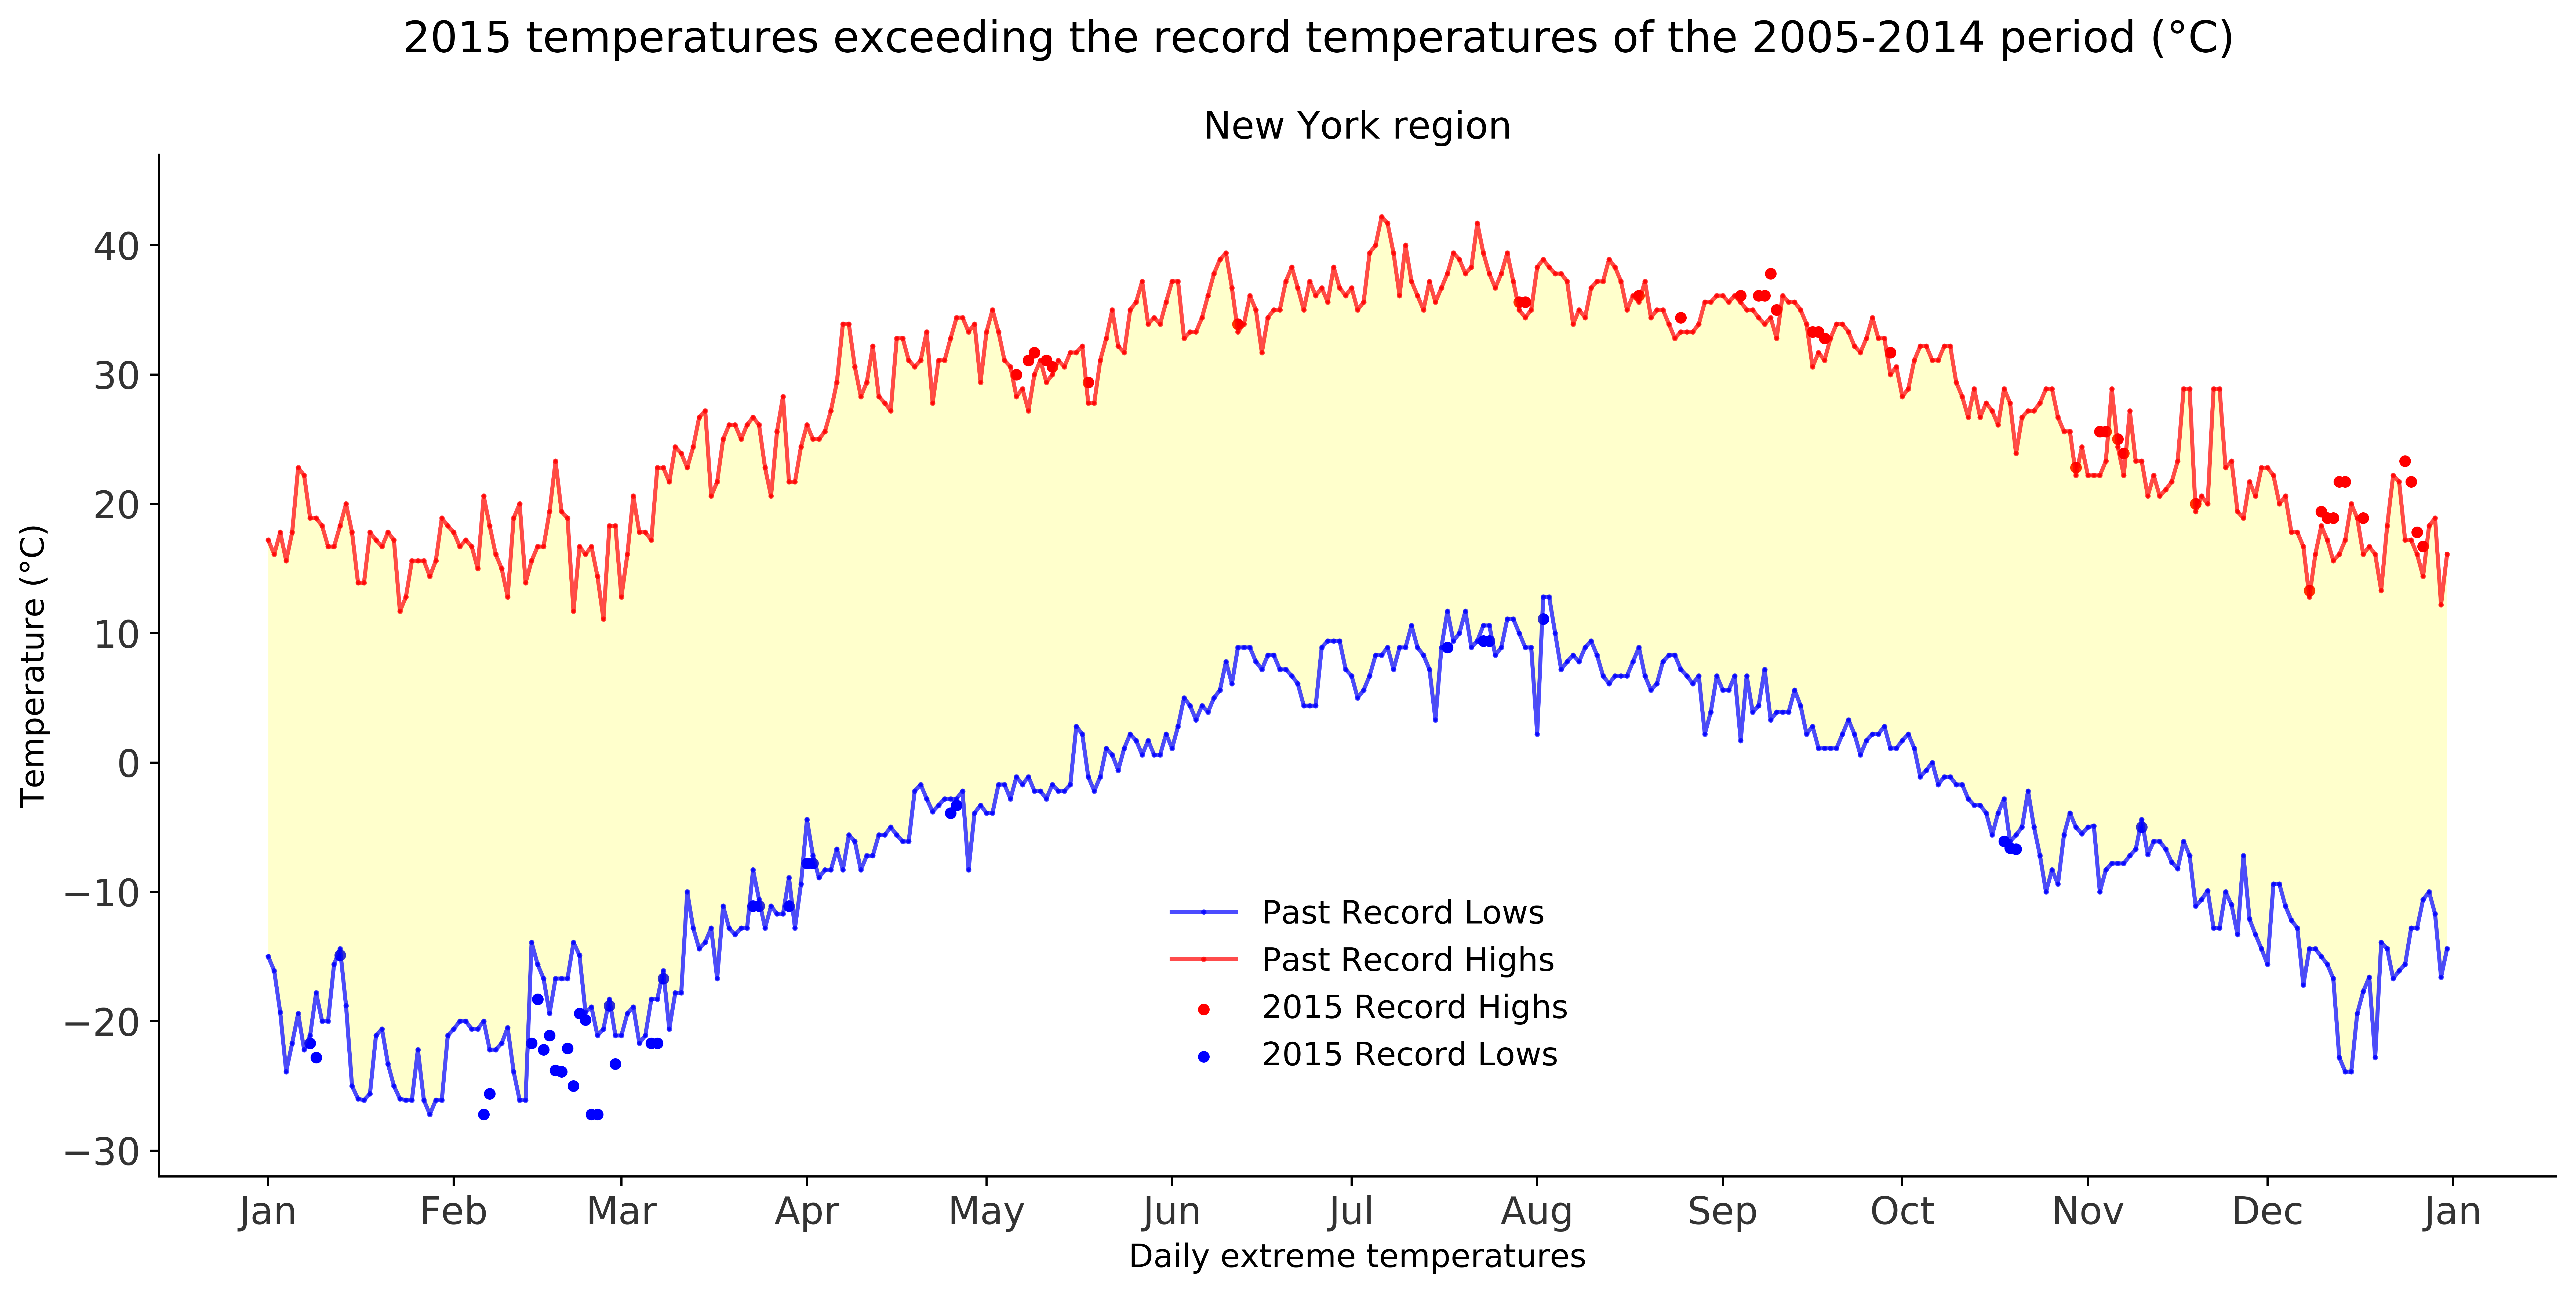

In [2]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
%matplotlib inline

# constants defined here for easy (manual) amendment:
#
comp_yr='2015'
region='New York region'

plot_file = 'Climate Data - {}.png'.format(region)
infile='./data/{}_climate.csv'.format(region.replace(' ', '_'))

#Load the data into a dataframe
df = pd.read_csv(infile)

# The IDs won't be used: the output will be the daily maximal & minimal temps of the longer period
df = df.drop('ID', axis=1)

# Parse year out of date, this works bc dates have fixed length:
df['Year'], df['MD'] = zip( *df['Date'].apply(lambda x: (x[:4]*1, x[5:])) )

# In the given 10-year period, there are several leap years; Remove the "leap" days: Feb 29
df = df[ df.MD != '02-29' ]

df = df.sort_values(by=['Year', 'MD', 'Element'])
# df.cols : ['Date', 'Element', 'Data_Value', 'Year', 'MD']

# Extract min max vectors (365 rows, 1 col):
# max/min record temperatures for the larger set:
data_min = df[ (df.Year != comp_yr) & (df.Element == 'TMIN') ].groupby('MD').Data_Value.min()/10
data_max = df[ (df.Year != comp_yr) & (df.Element == 'TMAX') ].groupby('MD').Data_Value.max()/10

# max/min record temperatures for the given year
comp_yr_max = df[ (df.Year == comp_yr) & (df.Element == 'TMAX') ].groupby('MD').Data_Value.max()/10
comp_yr_min = df[ (df.Year == comp_yr) & (df.Element == 'TMIN') ].groupby('MD').Data_Value.min()/10

# get decade-extreme temps for given year
comp_yr_above_max = (comp_yr_max > data_max).as_matrix()
comp_yr_below_min = (comp_yr_min < data_min).as_matrix()

# rest of plotting code .......................................................................
#
fig, ax = plt.subplots( figsize=(16,7), dpi=720 )
plt.title( region, fontsize=14 )

upper = int(df.Year.max()) - 1

plt.suptitle( '{} temperatures '.format( comp_yr )+
              'exceeding the record temperatures of the {}'.format( df.Year.min() )+
              '-{} period (°C)'.format( upper ), fontsize=16 )

# for yaxis limits; convert to full degrees with nudge
minT = round(df.Data_Value.min()/10)-5
maxT = round(df.Data_Value.max()/10)+5
ax.set_ylim( minT, maxT)

# x-axis data:
obs_range = np.arange('2015-01-01', '2016-01-01', dtype='datetime64[D]')
observation_axis = pd.to_datetime(obs_range)

#Past record temperatures
plt.plot( obs_range, data_min.as_matrix(), '-o', color='blue', ms=1, alpha=0.7 ) 
plt.plot( obs_range, data_max.as_matrix(), '-o', color='red', ms=1, alpha=0.7 ) 

#comp_yr record temperatures
plt.scatter( observation_axis[comp_yr_above_max], 
             comp_yr_max[comp_yr_above_max].as_matrix(), 
             s=11, c='r' )

plt.scatter( observation_axis[comp_yr_below_min], 
             comp_yr_min[comp_yr_below_min].as_matrix(),
             s=11, c='b' )

plt.xlabel('Daily extreme temperatures',fontsize=12)
plt.ylabel('Temperature (°C)',fontsize=12)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# remove top/right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# remove all their ticks 
plt.tick_params(top='off', right='off')

plt.xticks( size=14, alpha=0.8 )
plt.yticks( size=14, alpha=0.8 )

plt.legend( [ 'Past Record Lows', 
             'Past Record Highs', 
             '{} Record Highs'.format(comp_yr), 
             '{} Record Lows'.format(comp_yr) ], 
            bbox_to_anchor=(0.6, 0.3),
            frameon = False,  prop={'size':12} )
# alternate way to place box (overwrites loc='lower center' if given): bbox_to_anchor=(1.0, 0.5) )

ax.fill_between( observation_axis, data_min, data_max, facecolor='yellow', alpha=0.20 )

plt.show()

fig.savefig( fname='./img/'+plot_file, dpi=500, orientation='landscape', transparent=True, frameon=None )